In [1]:
import glob
import tensorflow as tf
from pathlib import Path
import imghdr

In [2]:
images_folder = '../images'

In [3]:
data_dir = "../images/"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

Shape of the image: (1458, 1920, 3)


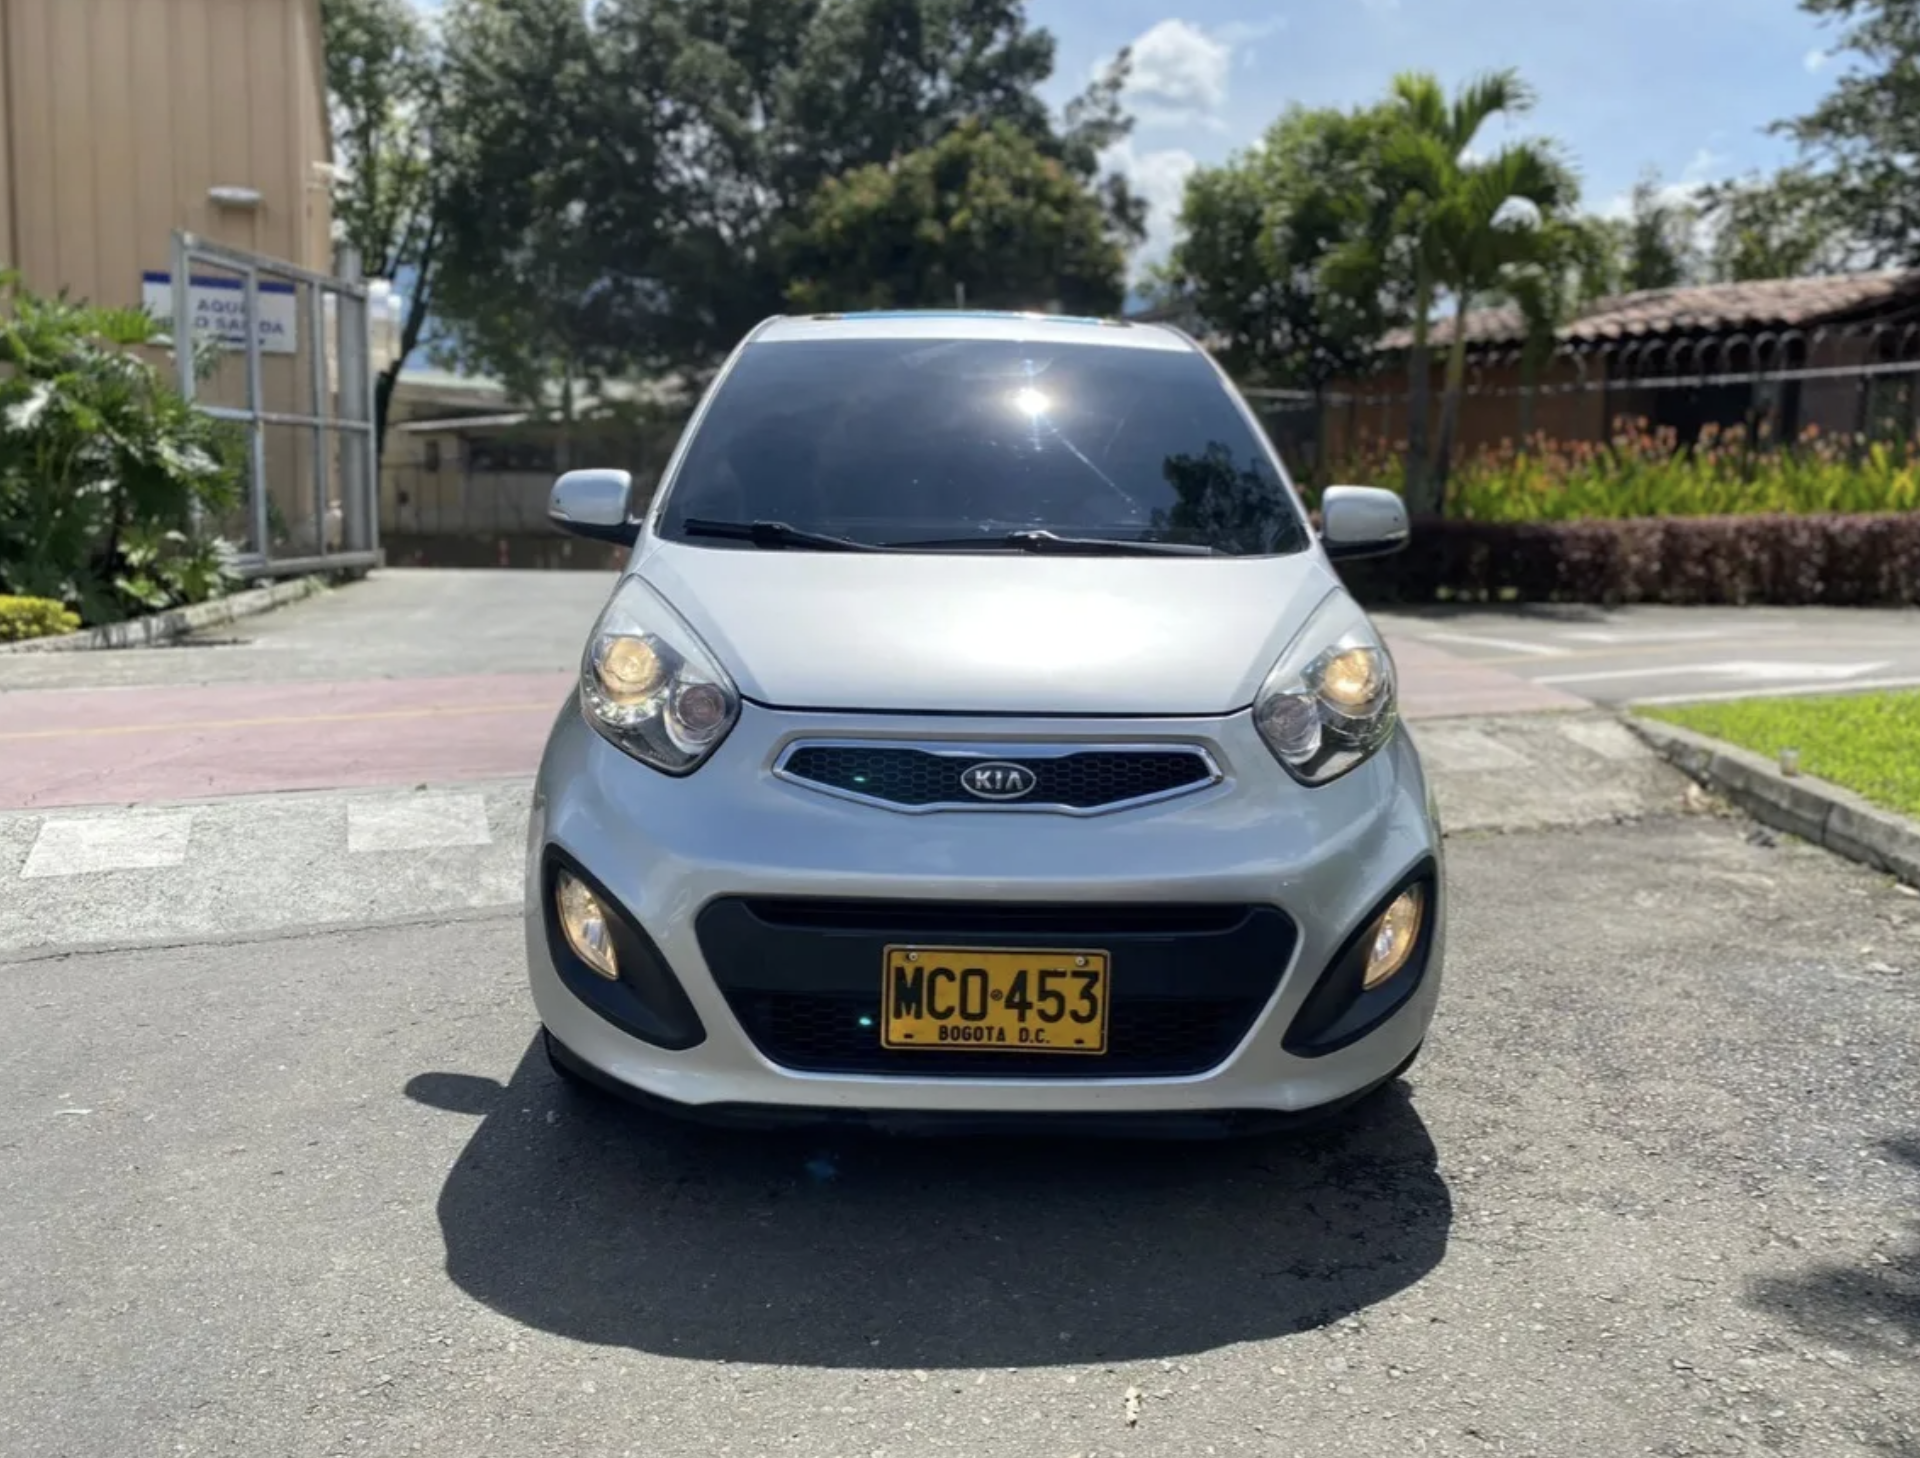

In [4]:
# test load image
image_files = glob.glob(images_folder + '/*/*.png')
image = image_files[-1]

pil_image = tf.keras.preprocessing.image.load_img(image)
tf_image = tf.keras.preprocessing.image.img_to_array(pil_image)
print(f'Shape of the image: {tf_image.shape}')
pil_image

The image has a big resolution (1920 x 1458 x 3) which needs to be reduced for computational purposes.

In [5]:
# callback
class AccReached(tf.keras.callbacks.Callback):
  def __init__(self):
    pass
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True


In [7]:
# import images
train_images = tf.keras.preprocessing.image_dataset_from_directory(
  images_folder,
  labels='inferred',
  image_size=(256, 256),
  batch_size=8,
  shuffle=True,
  validation_split=0.2,
  subset='training',
  seed=42,
)
validation_images = tf.keras.preprocessing.image_dataset_from_directory(
  images_folder,
  labels='inferred',
  image_size=(256, 256),
  batch_size=8,
  shuffle=False,
  validation_split=0.2,
  subset='validation',
  seed=42,
)
labels = train_images.class_names
train_images = train_images.map(lambda x, y: (x / 255.0, y))
validation_images = validation_images.map(lambda x, y: (x / 255.0, y))

Found 2097 files belonging to 3 classes.
Using 1678 files for training.
Found 2097 files belonging to 3 classes.
Using 419 files for validation.


In [8]:
model = tf.keras.models.Sequential([
    # tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(256, 256, 3)),
    # tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [9]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=tf.optimizers.SGD(learning_rate=0.001),
  metrics=['accuracy'],
)

In [10]:
history = model.fit(
  train_images.repeat(),
  steps_per_epoch=211,
  epochs=20,
  verbose=1,
  callbacks=[AccReached()],
  validation_data=validation_images,
)

Epoch 1/20


2022-11-06 19:05:34.669969: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-06 19:05:35.199952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.5961

2022-11-06 19:05:53.036566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - 20s 89ms/step - loss: 0.9240 - accuracy: 0.5961 - val_loss: 1.2436 - val_accuracy: 0.2482
Epoch 2/20
211/211 [==============================] - 18s 85ms/step - loss: 0.7877 - accuracy: 0.6661 - val_loss: 0.8879 - val_accuracy: 0.5084
Epoch 3/20
211/211 [==============================] - 18s 86ms/step - loss: 0.7299 - accuracy: 0.6809 - val_loss: 0.6954 - val_accuracy: 0.7041
Epoch 4/20
211/211 [==============================] - 18s 85ms/step - loss: 0.6764 - accuracy: 0.7236 - val_loss: 1.5538 - val_accuracy: 0.2100
Epoch 5/20
211/211 [==============================] - 18s 83ms/step - loss: 0.6561 - accuracy: 0.7325 - val_loss: 1.3093 - val_accuracy: 0.2625
Epoch 6/20
211/211 [==============================] - 18s 84ms/step - loss: 0.6051 - accuracy: 0.7604 - val_loss: 0.6392 - val_accuracy: 0.7422
Epoch 7/20
211/211 [==============================] - 18s 84ms/step - loss: 0.5686 - accuracy: 0.7871 - val_loss: 0.7866 - val_accuracy: 0.6038
Epo

In [ ]:
# prediction
new_image = image_files[50]
pil_image = tf.keras.preprocessing.image.load_img(new_image, target_size=(256, 256))
tf_image = tf.keras.preprocessing.image.img_to_array(pil_image)
probs = model.predict(tf_image.reshape(1, 256, 256, 3))
print(f'Model prediction: {labels[probs.argmax()]}')
pil_image

In [ ]:
# save the model
model.save('labeling_model.h5')

In [ ]:
labels